# Documentation

**Written:** Mu-Ting Chien, August 2nd, 2021

**Edited:** Spencer Ressel, June 9th, 2022

*** 
This script computes the space-time power spectrum of an input signal, using 
the method described in Wheeler and Kiladis 2009 (WK99), among others. 
***

**Inputs:**
* Global resolution, daily timeseries in netCDF format
    - NOAA OLR *(Liebmann and Smith, 1996)*
    - TRMM precipitation
    
**Outputs:**
* Power Spectra including background and raw symmetric and asymmetric 

**Dependencies:**
* mjo_mean_state_diagnostics.py
* one_two_one_filter.ipynb

# Imports

In [1]:
print("Loading imports...")
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import colors as mcolors

# sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
sys.path.insert(0, '/glade/u/home/sressel/auxiliary_functions/')
# import mask_land as ml
import numpy as np
import math
import scipy.signal as signal
# import colormaps as cmaps

import mjo_mean_state_diagnostics as mjo
from one_two_one_filter import one_two_one_filter
print("Imports loaded")

Loading imports...
Imports loaded


# Specify parameters

In [6]:
dataset = 'TRMM'
time_limits = ('2000-01-01', '2014-01-01')

trange = str(time_limits[0])[:4] + '-' +str(time_limits[1])[:4]
max_latitude = 30
mask_land = True

plot_raw_spectrum = False
plot_background_spectrum = False
plot_signal_strength = True
save_plots = False
n_smooths = 15

# Load data

In [7]:
# Specify data location
data_directory = "/home/disk/eos7/sressel/research/data/"
variable_name = {}

print(f"Dataset: {dataset}")
print(f"{'':{'='}^{30}}")
print(f"Loading data...")
# Load data
if dataset == 'NOAA':
    variable_name[dataset] = 'OLR'
    loaded_data = xr.open_dataset(f"{data_directory}/NOAA/olr.day.mean.nc")
    # The OLR data goes from 90 to -90 by default
    data = loaded_data['olr'].isel(lat=slice(None, None, -1))
    lat = data['lat'].isel(lat=slice(None, None, -1))
elif dataset == 'TRMM':
    variable_name[dataset] = 'PR'
    loaded_data = xr.open_dataset(f"{data_directory}/NASA/TRMM/trmm_precipitation_daily_1998_2018.nc")
    data = loaded_data['precipitation']
    lat = data['lat']

time = data['time']
lon = data['lon']
print(f"Data loaded")
print(f"{'':{'='}^{30}}")


# # Subset the data according to the specified parameters
print("Subsetting data...")
data_subset = data.sel(time=slice(time_limits[0], time_limits[1]), lat=slice(-max_latitude, max_latitude))
time_subset = time.sel(time=slice(time_limits[0], time_limits[1]))
lat_tropics = lat.sel(lat=slice(-max_latitude, max_latitude))
print("Data subset")
print(f"{'':{'='}^{30}}")

Dataset: TRMM
Loading data...


FileNotFoundError: [Errno 2] No such file or directory: '/home/disk/eos7/sressel/research/data/NASA/TRMM/trmm_precipitation_daily_1998_2018.nc'

# Pre-process signal

## Remove annual cycle

In [104]:
print(f"{'':{'='}^{30}}")
print("Remvoing annual cycle...")
# Remove annual cycle and first three harmonics (as in WK99)
deannualized_data_tropics, annual_cycle = mjo.remove_annual_cycle(data_subset)
print(f"Annual cycle removed")
print(f"{'':{'='}^{30}}")

Remvoing annual cycle...
Annual cycle removed


## Mask land

In [105]:
print(f"{'':{'='}^{30}}")
print(F"Land masking {('on' if mask_land else 'off')}")
if mask_land == True:
    print("   → Loading land data...")
    # Specify land data directory
    land_data_file = f"{data_directory}/NCEP/NCEP_land_2.5deg.nc"

    land_mask_data = xr.open_dataarray(land_data_file)
    land_mask_data = land_mask_data.isel(lat=slice(None, None, -1)).sel(lat=slice(-max_latitude, max_latitude))

    print("   → Masking land...")
    masked_data_tropics = deannualized_data_tropics.where(land_mask_data == 0)
    processed_data = masked_data_tropics
    print("Land masked")
    print(f"{'':{'='}^{30}}")
else:
    processed_data = deannualized_data_tropics

Land masking on
   → Loading land data...
   → Masking land...
Land masked


# WOSA

In [106]:
print("Calculate space-time spectra")
print(f"{'':{'='}^{30}}")

print("   → Computing symmetric and asymmetric signals...")
# Separate into symmetric/antisymmetric component
symmetric_signal = xr.zeros_like(processed_data.sel(lat=slice(0, max_latitude)))
asymmetric_signal = xr.zeros_like(processed_data.sel(lat=slice(0, max_latitude)))

for latitude_index, latitude in enumerate(symmetric_signal.lat):
    symmetric_signal[:, latitude_index, :] = (
        processed_data.sel(lat=latitude) + processed_data.sel(lat=-latitude)
    )/2
    asymmetric_signal[:, latitude_index, :] = -(
        processed_data.sel(lat=latitude) - processed_data.sel(lat=-latitude)
    )/2

symmetric_signal = symmetric_signal.fillna(0)
asymmetric_signal = asymmetric_signal.fillna(0)

# Subset into segments in time (96 days, overlap 60 days)
segment_length = 96
overlap = 60
window_width = 5

# Define the Hann window
hann_window = np.concatenate(
    (
        np.hanning(window_width),
        np.ones(segment_length - window_width * 2),
        np.hanning(window_width),
    ),
    axis=0,
)

print("   → Segmenting data...")
# Segment the data
symmetric_signal_segmented = symmetric_signal.rolling(
    time=segment_length, center=False
).construct("segment_index")[(segment_length-1):][::(segment_length-overlap)].transpose("time", "segment_index", "lat" , "lon")

asymmetric_signal_segmented = asymmetric_signal.rolling(
    time=segment_length, center=False
).construct("segment_index")[(segment_length-1):][::(segment_length-overlap)].transpose("time", "segment_index", "lat" , "lon")

print("   → Detrending segmented data...")
# Detrend the data along the segmented axis
symmetric_signal_detrended = symmetric_signal_segmented.copy(deep=True)
asymmetric_signal_detrended = asymmetric_signal_segmented.copy(deep=True)
symmetric_signal_detrended.values = signal.detrend(symmetric_signal_segmented, axis=1)
asymmetric_signal_detrended.values = signal.detrend(asymmetric_signal_segmented, axis=1)

print("   → Windowing segmented data...")
# Apply the Hann window to each segment
symmetric_signal_windowed = symmetric_signal_detrended.copy(deep=True)
asymmetric_signal_windowed = asymmetric_signal_detrended.copy(deep=True)
symmetric_signal_windowed.values = np.einsum(
    'j,ijkl->ijkl',
    hann_window,
    symmetric_signal_detrended
)
asymmetric_signal_windowed.values = np.einsum(
    'j,ijkl->ijkl',
    hann_window,
    asymmetric_signal_detrended
)

print("   → Fourier transforming segmented data...")
# Fourier transform the data and calculate raw power
symmetric_signal_fft = np.fft.fft2(
    symmetric_signal_windowed, axes=(1, 3)
) / (len(lon) * segment_length)* 4
raw_symmetric_power = np.fft.fftshift(
    np.mean(
        np.real(
            symmetric_signal_fft*np.conj(symmetric_signal_fft)
        ), axis=(0,2)
    )
)

asymmetric_signal_fft = np.fft.fft2(
    asymmetric_signal_windowed, axes=(1, 3)
) / (len(lon) * segment_length)* 4
raw_asymmetric_power = np.fft.fftshift(
    np.mean(
        np.real(
            asymmetric_signal_fft*np.conj(asymmetric_signal_fft)
        ), axis=(0,2)
    )
)

# Calculate the frequency and zonal wavenumber axis coordinates
frequency = (
    np.arange(-segment_length / 2, segment_length / 2) * 1 / segment_length
)
zonal_wavenumber = np.arange(-len(lon) / 2, len(lon) / 2) * (1/2.5) / len(lon) * 360
x, y = np.meshgrid(zonal_wavenumber, -frequency)

#### 1-2-1 Filtering
print("   → 1-2-1 filtering background...")
# Smooths the background spectrum 'n_smooths' times
background_spectrum = (raw_symmetric_power + raw_asymmetric_power) / 2
background_spectrum = one_two_one_filter(background_spectrum, n_smooths, "time")
background_spectrum = one_two_one_filter(background_spectrum, n_smooths, "space")

# Calculate signal strength as raw/smoothed background
symmetric_power_spectrum = raw_symmetric_power / background_spectrum
asymmetric_power_spectrum = raw_asymmetric_power / background_spectrum

print(f"{'':{'='}^{30}}")
print("Space-time spectra calculated")

# remove artificial signal from satellite: only for olr, not precip
if dataset == "NOAA":
    print(f"{'':{'='}^{30}}")
    print(f"Dataset is NOAA")
    print("   → Removing artifical sigmal...")
    aa = np.array([1, -1])
    for a in range(0, 2):
        iymin = np.argwhere(zonal_wavenumber == 14).squeeze()
        iymax = np.argwhere(zonal_wavenumber == 15).squeeze()
        fmin = 0.1 * aa[a]
        fmax = 0.15 * aa[a]
        dmin = np.abs(frequency - fmin)
        dmax = np.abs(frequency - fmax)
        ixmin = np.argwhere(dmin == np.min(dmin)).squeeze()
        ixmax = np.argwhere(dmax == np.min(dmax)).squeeze()
        if a == 0:
            symmetric_power_spectrum[ixmin : ixmax + 1, iymin : iymax + 1] = 0
        elif a == 1:
            symmetric_power_spectrum[ixmax : ixmin + 1, iymin : iymax + 1] = 0
    print("Artifical signal removed")
    print(f"{'':{'='}^{30}}")

Calculate space-time spectra
   → Computing symmetric and asymmetric signals...
   → Segmenting data...
   → Detrending segmented data...
   → Windowing segmented data...
   → Fourier transforming segmented data...
   → 1-2-1 filtering background...
Space-time spectra calculated


# Plot spectra

## Specify output directory & plotting parameters

In [107]:
# Create a directory for the output figures
output_directory = "/home/disk/eos7/sressel/research/thesis-work/python/mjo_data_analysis/output/"
figures_folder = f"{output_directory}/power_spectra/{dataset}/"

print(f"{'':{'='}^{30}}")
if not os.path.exists(figures_folder):
    print('Creating figure directory...')
    print(f"{'':{'='}^{30}}")
    os.mkdir(figures_folder)
    print("Figures folder created")
else:
    print("Figures folder exists")
print(f"{'':{'='}^{30}}")

# Plotting parameters
plt.style.use('default')
plt.rcParams.update({'font.size': 18})

Figures folder exists


## Raw Spectrum

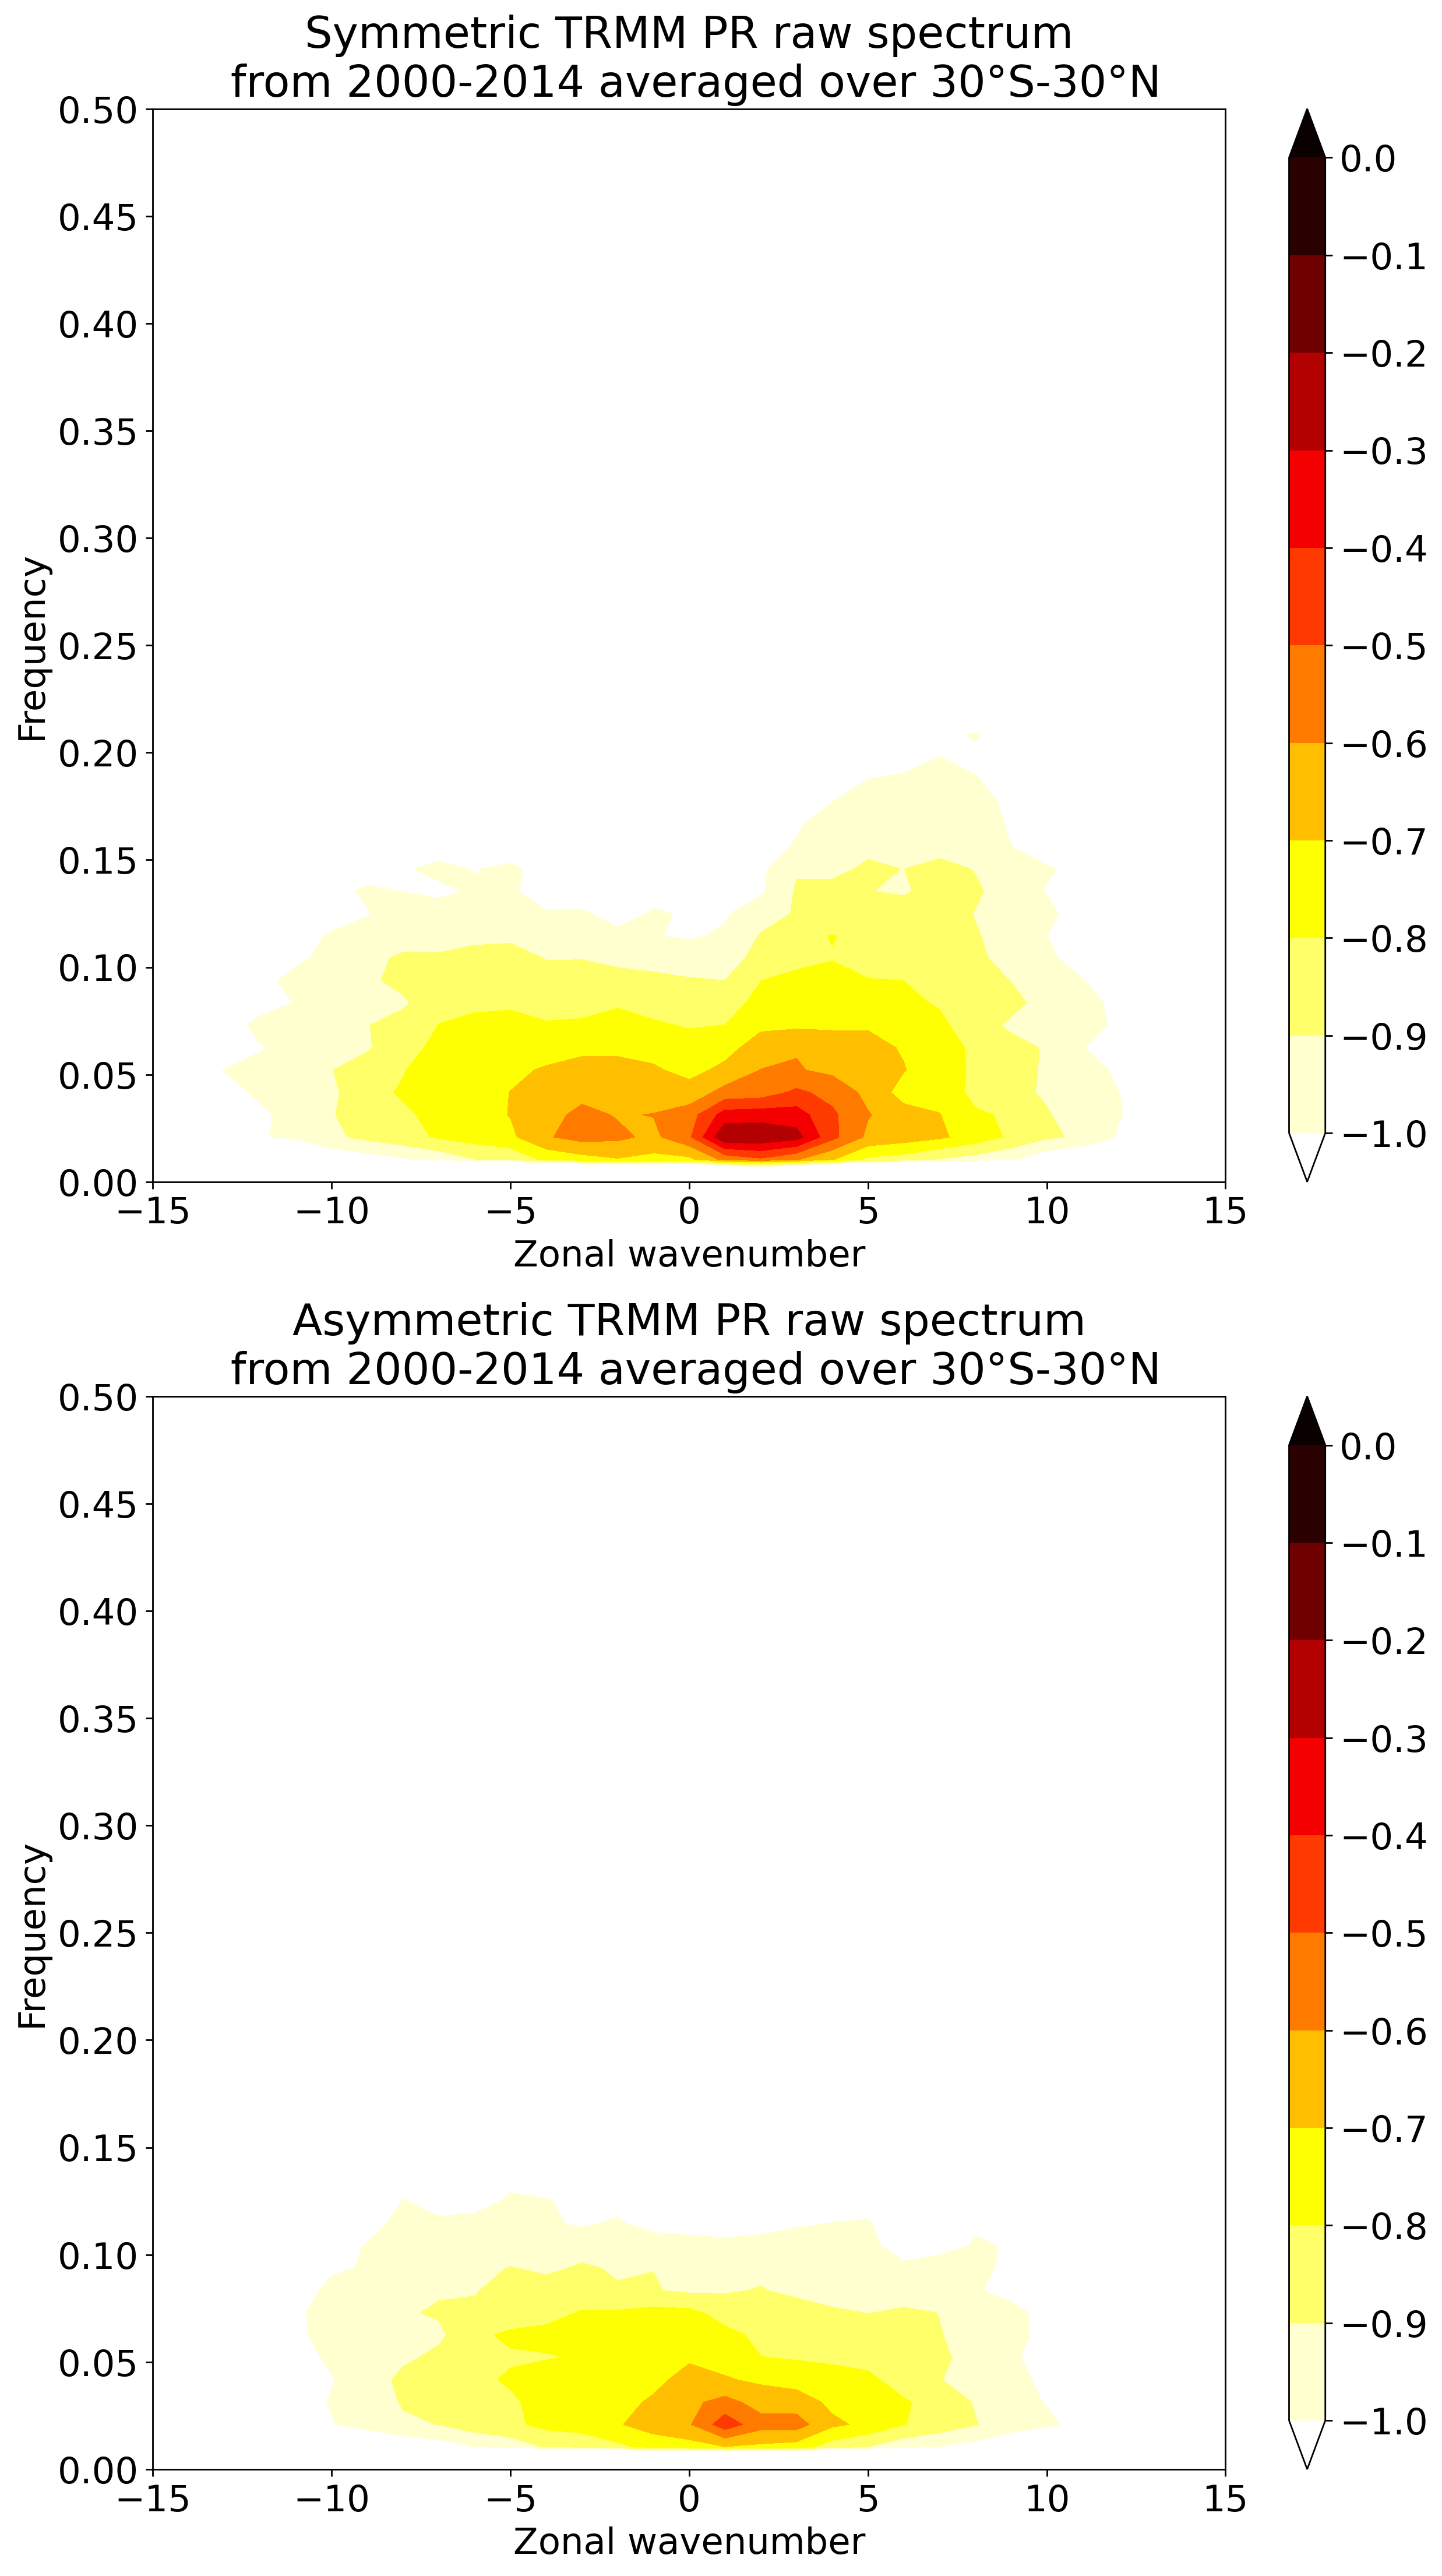

In [108]:
# Plot symmetric spectrum
fig = plt.figure(figsize=(9,18), dpi=250)
gs_main = gs.GridSpec(2, 2, width_ratios=[30, 1], figure=fig)
gs_main.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.2)

ax = []
cbar_ax = []
ax.append(fig.add_subplot(gs_main[0,0]))
ax.append(fig.add_subplot(gs_main[1,0]))
cbar_ax.append(fig.add_subplot(gs_main[0,1]))
cbar_ax.append(fig.add_subplot(gs_main[1,1]))

ax[0].set_title(
    f"Symmetric {dataset} {variable_name[dataset]} raw spectrum"
    + f"\n from {trange} averaged over {max_latitude}°S-{max_latitude}°N"
)

# Specify contour levels
contour_levels = np.arange(-1,0.1,0.1)
CF0 = ax[0].contourf(
    x,
    y,
    np.log10(raw_symmetric_power),
    cmap='hot_r',
    levels=contour_levels,
    extend='both'
)
cb0 = fig.colorbar(CF0, cax=cbar_ax[0], orientation = 'vertical', shrink=.9)
cb0.set_ticks(contour_levels)


ax[1].set_title(
    f"Asymmetric {dataset} {variable_name[dataset]} raw spectrum"
    + f"\n from {trange} averaged over {max_latitude}°S-{max_latitude}°N"
)

CF1 = ax[1].contourf(
    x,
    y,
    np.log10(raw_asymmetric_power),
    cmap='hot_r',
    levels=contour_levels,
    extend='both'
)
cb1 = fig.colorbar(CF1, cax=cbar_ax[1], orientation = 'vertical', shrink=.9)
cb1.set_ticks(contour_levels)

for axis in range(len(ax)):
    ax[axis].set_ylabel('Frequency')
    ax[axis].set_xlabel('Zonal wavenumber')
    ax[axis].set_xlim(-15,15)
    ax[axis].set_ylim(0, 0.5)
    ax[axis].set_xticks(np.arange(-15, 20, 5))
    ax[axis].set_yticks(np.arange(0, 0.55, 0.05))
    ax[axis].set_aspect(30/0.5)

plt.show()

## Power Spectra

Plotting symmetric signal
Plotting asymmetric signal


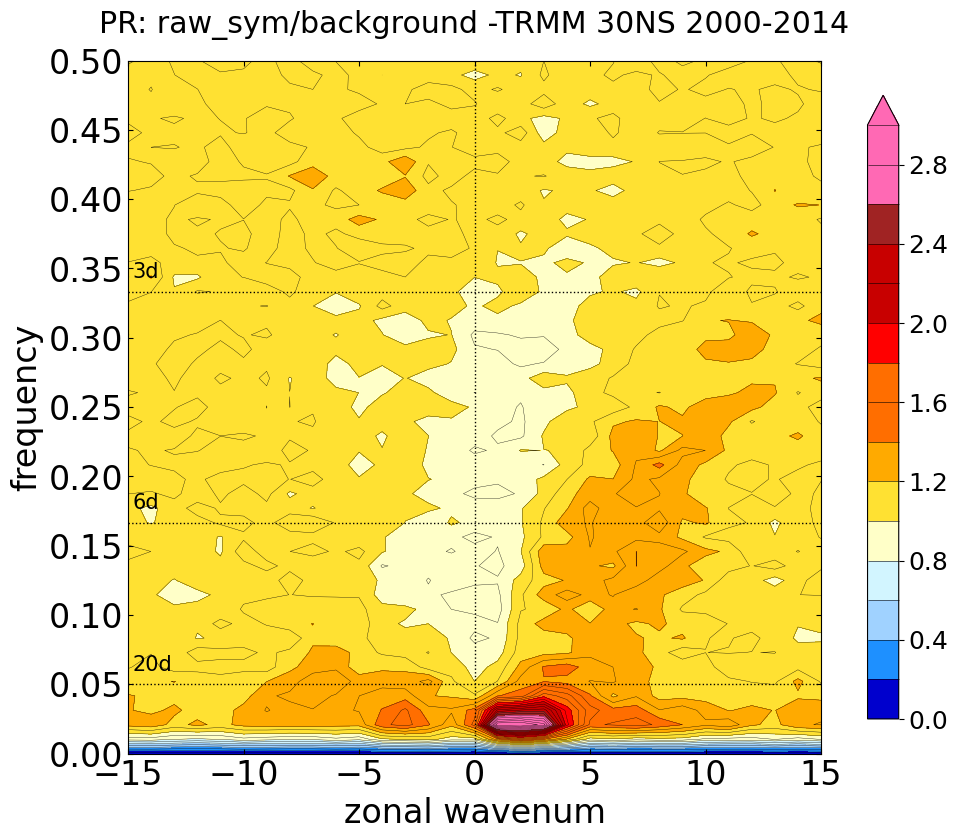

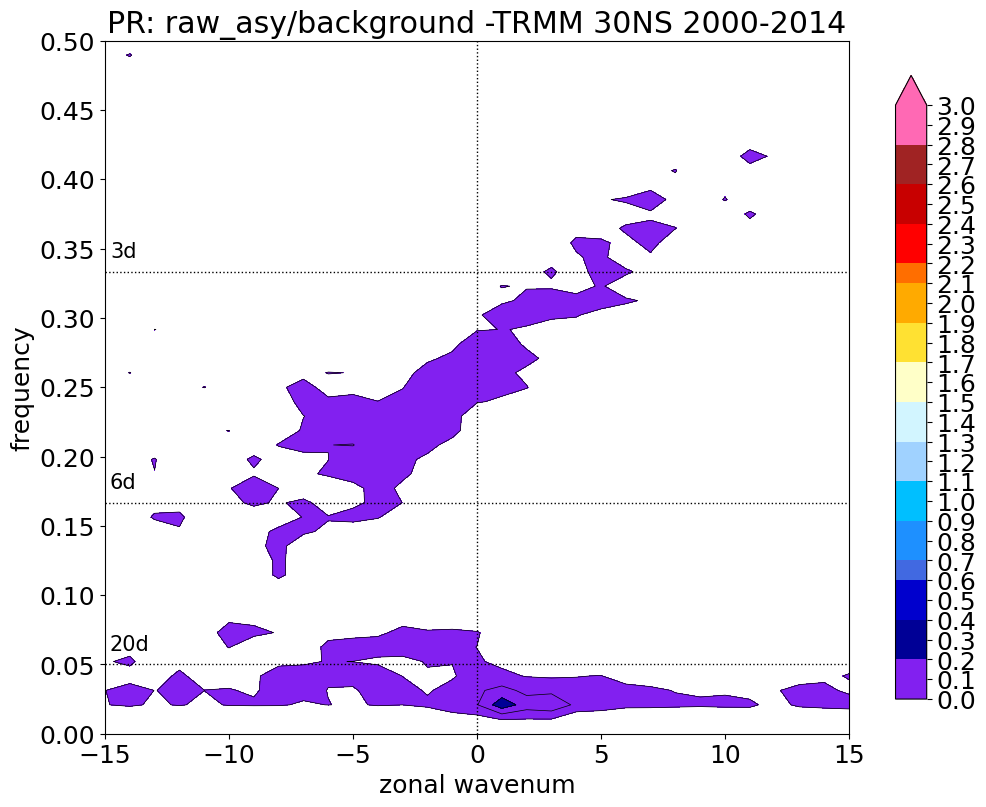

In [109]:
# Plotting parameters
g = 9.8 # m/s^2
eq_depth = np.array([8,25,250]) # Equivalent Depths (m)
plot_days = np.array([3,6,20]) # mark 3, 6, 20 day in WK1999
earth_radius = 6371*1000 # Earth radius (m)

plt.rcParams.update({'font.size':24})

# Plot background spectrum
if plot_background_spectrum == True:
    print('Plotting background spectrum')
    print('======================')

    # Plot background spectrum-smooth (sym-asy mixed)
    plt.figure(figsize=(12,9))
    contour_levels = np.arange(-1,0.1,0.1)
    plt.contourf(x,y,np.log10(background_spectrum),
                 cmap='hot_r',
                 levels = contour_levels,
                 extend='both')
    cb = plt.colorbar(orientation = 'vertical',shrink=.9)
    cb.set_ticks(contour_levels)
    plt.title(variable_name[dataset] + ' (sym+asy)/2: smooth (log) -' +\
                                     dataset + ' ' + str(max_latitude) + 'NS ' + trange)
    plt.ylabel('frequency')
    plt.xlabel('zonal wavenum')
    plt.axis([-15,15,0,0.5])
    plt.xticks([-15,-10,-5,0,5,10,15])
    plt.yticks(np.arange(0,0.55,0.05))
    if save_plots == True:
        plt.savefig(figures_folder+variable_name[dataset]+\
         '_background_' + str(n_smooths) + 'cyc_smooth_' + str(max_latitude) + 'NS.png') 
        plt.close()

# Plot signal strength
if plot_signal_strength == True:
    print('Plotting symmetric signal')
    print('======================')

    color_map = cmaps.amwg_blueyellowred

    if dataset == 'NOAA':
        # contour_levels = np.arange(0,3.1,0.1)
        contour_levels = np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.4,1.7,2,2.4,2.8,3.2])
        # contour_levels = np.arange(0,3.2,0.4)
    elif dataset == 'TRMM':
        contour_levels = np.arange(0,3.1,0.1)

    # Plot symmetric signal strength
    plt.figure(figsize=(12,9))
    cf = plt.contourf(x, y, symmetric_power_spectrum,
                      cmap = color_map, levels = 16,
                      norm = mcolors.PowerNorm(gamma=0.525), extend='max')
    plt.rcParams.update({'font.size': 18})
    cb = plt.colorbar(orientation = 'vertical',shrink=.9, drawedges=True)
    # cb = plt.colorbar(orientation = 'horizontal',shrink=.9)
    # cb.set_ticks(np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.4,1.7,2,2.4,2.8,3.2]))
    # cb.set_ticklabels(["","0.3","0.4","0.5","0.6","0.7","0.8","0.9",
    #               "1","1.1","1.2","1.4","1.7","2","2.4","2.8",""])
    plt.contour(cf, colors='black',linewidths=0.25, levels=contour_levels)

    # Mark 3, 6, 20 day period:
    for day in plot_days:
        plt.axhline(1/day, color='black', lw=1, ls=':')
        plt.text(-14.8, 1/day+0.01, str(day) + 'd', fontsize=15)

    # # Mark CCKW dispersion relationship:
    # yloc = np.array([0.47,0.47,0.47])
    # cp = (g*eq_depth)**0.5*86400 # seconds to days
    # zwnum_goal = 2*np.pi*earth_radius*0.5/cp
    # for hh in range(0,np.size(eq_depth)):
    #     plt.plot([0,zwnum_goal[hh]],[0,0.5],'k',
    #              linewidth=1,linestyle=(0,(5,5)))
    #     plt.text(np.around(zwnum_goal)[hh],yloc[hh],
    #              (str(eq_depth[hh]) + 'm'), fontsize=15)

    # Mark zonal wavenumber 0:
    plt.axvline(x=0,color='black',lw=1,ls=':')

    # Plot Labelling
    plt.title(variable_name[dataset]+': raw_sym/background -'+\
              dataset+' '+str(max_latitude)+'NS '+trange, pad=20)
    plt.ylabel('frequency')
    plt.xlabel('zonal wavenum')
    plt.axis([-15,15,0,0.5])
    plt.xticks([-15,-10,-5,0,5,10,15])
    plt.yticks(np.arange(0,0.55,0.05))
    plt.tick_params(bottom=True,top=True,left=True,right=True)
    plt.tick_params(labelbottom=True,labeltop=False,
                    labelleft=True,labelright=False)
    plt.tick_params(direction="in")
    plt.gca().set_aspect(30/0.5)

    # Save the figure as a png
    if save_plots == True:
        plt.savefig(figures_folder+variable_name[dataset]+\
                    '_ratio_sym_'+str(max_latitude)+'NS_purplebox.png')
        plt.close()

    # Plot asymmetric signal strength
    print('Plotting asymmetric signal')
    print('======================')
    plt.figure(figsize=(12,9))
    plt.rcParams.update({'font.size': 18})
    cf = plt.contourf(x,y,np.log10(asymmetric_power_spectrum),
                      cmap=color_map,
                      levels = contour_levels,
                      extend='max')
    cb = plt.colorbar(orientation = 'vertical',shrink=.9)
    cb.set_ticks(contour_levels)
    plt.contour(cf, colors='k',linewidths=0.5)

    # Mark 3, 6, 20 day period:
    for day in plot_days:
        plt.axhline(y=1/day,color='k',lw=1, ls=':')
        plt.text(-14.8, 1/day+0.01, str(day) + 'd', fontsize=15)

    # Mark zonal wavenumber == 0:
    plt.axvline(x=0, color='k', lw=1, ls=':')

    # Plot labelling
    plt.title(variable_name[dataset]+\
              ': raw_asy/background -' +\
                  dataset + ' ' + str(max_latitude) + 'NS ' + trange)
    plt.ylabel('frequency')
    plt.xlabel('zonal wavenum')
    plt.axis([-15,15,0,0.5])
    plt.xticks([-15,-10,-5,0,5,10,15])
    plt.yticks(np.arange(0,0.55,0.05))

    # Save figure as png
    if save_plots == True:
        plt.savefig(figures_folder+variable_name[dataset]+'_ratio_asy_'+str(max_latitude)+'NS.png')
        plt.close()